# Multi-Label Text classification problem with Keras

Building a model with Multiple-Outputs and Multiple-Losses in Keras

### Importing Libraries

In [1]:
import pandas as pd
import re
from sqlalchemy import create_engine
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input
from keras.layers.embeddings import Embedding

### Loading data from database.

The dataset consists of real messages that are classified into 36 different classes.
The problem conists of a multi-label classfication problem, where one message can be 
classified into more than 1 class.

In [4]:
# load data from database
engine = create_engine('sqlite:///data/DisasterResponse.db')

In [5]:
df = pd.read_sql_table('messages', engine) # Table Message

#### Output Columns Distributions

In [6]:
output_columns_all = ['related', 'request', 'offer', 'aid_related',
       'medical_help', 'medical_products', 'search_and_rescue', 'security',
       'military', 'child_alone', 'water', 'food', 'shelter', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']

As we can observe from the graphs below, the dataset is highly imbalanced. Some classes are more balanced than others.

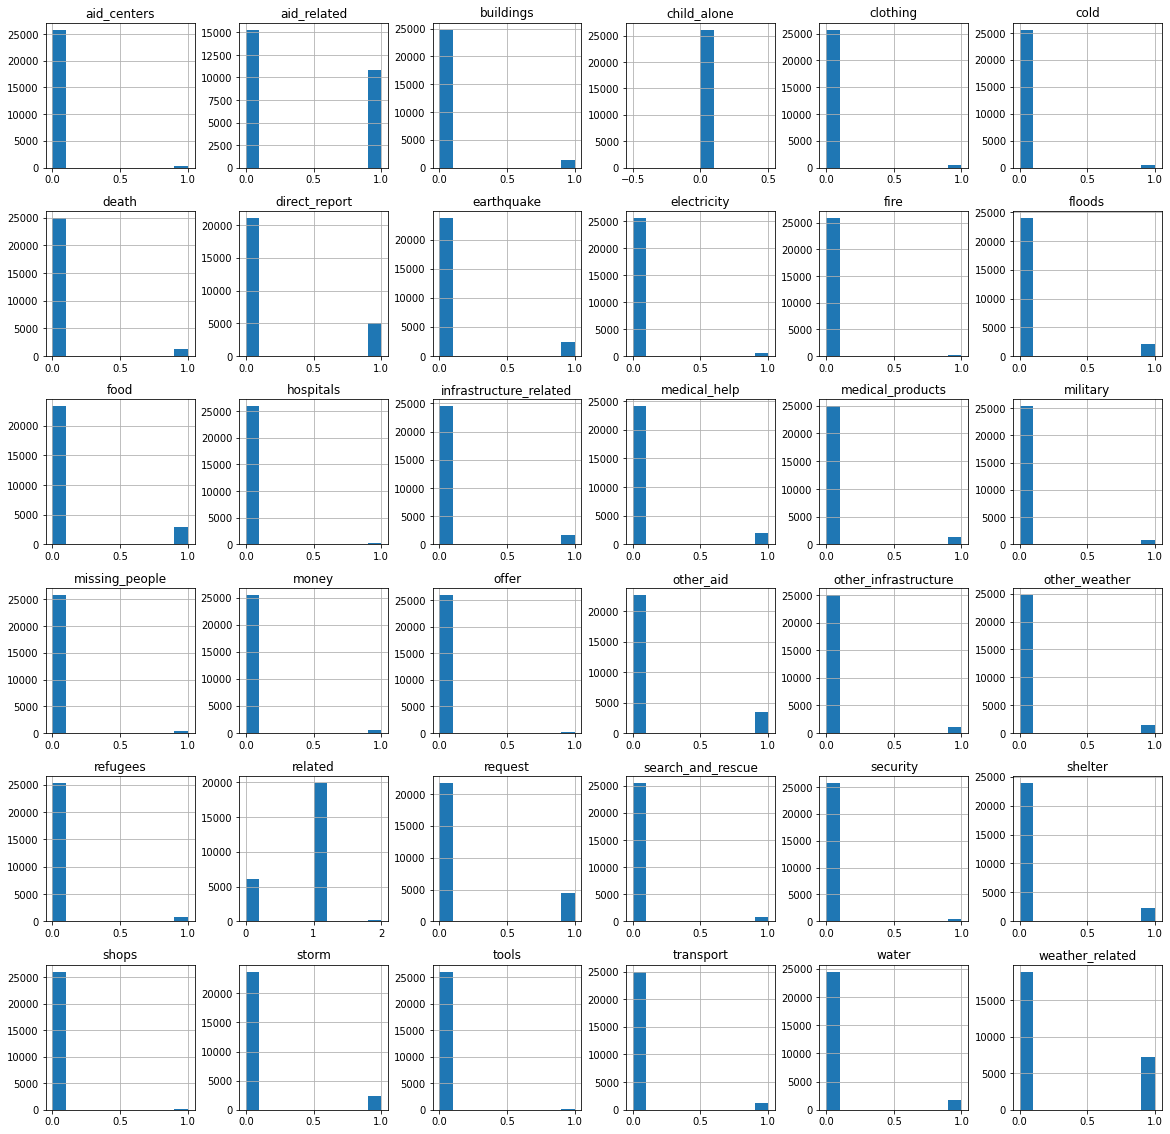

In [7]:
df[output_columns_all].hist(figsize=(20,20));

#### Inputs

In [8]:
list(df['message'].head())

['Weather update - a cold front from Cuba that could pass over Haiti',
 'Is the Hurricane over or is it not over',
 'Looking for someone but no name',
 'UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.',
 'says: west side of Haiti, rest of the country today and tonight']

### Data Preparation

In [9]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [10]:
def clean_text(text):
    text = text.lower()
    
    # '@' mention. Even tough @ adds some information to the message, 
    # this information doesn't add value build the classifcation model
    text = re.sub(r'@[A-Za-z0-9_]+','', text)
    
    # Dealing with URL links
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex,'urlplaceholder', text)
    # A lot of url are write as follows: http bit.ly. Apply Regex for these cases
    utl_regex_2 = 'http [a-zA-Z]+\.[a-zA-Z]+'
    text = re.sub(utl_regex_2,'urlplaceholder', text)
    # Other formats: http : //t.co/ihW64e8Z
    utl_regex_3 = 'http \: //[a-zA-Z]\.(co|com|pt|ly)/[A-Za-z0-9_]+'
    text = re.sub(utl_regex_3,'urlplaceholder', text)
    
    # Hashtags can provide useful informations. Removing only ``#``
    text = re.sub('#',' ', text)
    
    # Contractions
    text = re.sub(r"what's", 'what is ', text)
    text = re.sub(r"can't", 'cannot', text)
    text = re.sub(r"\'s",' ', text)
    text = re.sub(r"\'ve", ' have ', text)
    text = re.sub(r"n't", ' not ', text)
    text = re.sub(r"im", 'i am ', text)
    text = re.sub(r"i'm", 'i am ', text)
    text = re.sub(r"\'re", ' are ', text)
    text = re.sub(r"\'d", ' would ', text)
    text = re.sub(r"\'ll", ' will ', text)
                  
    # Operations and special words           
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub('foof', 'food', text)
    text = re.sub('msg', 'message', text)
    text = re.sub(' u ', 'you', text)
    
    # Ponctuation Removal
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    text = text.split()
    stop_words = stopwords.words("english")
    text = [tok for tok in text if tok not in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    return ' '.join(text)
    

### Tokenize and Create Sentence

In [11]:
# Cleaning Text
df['message'] = df['message'].map(lambda x: clean_text(x))

#### Chossing size of vocabulary

In [12]:
vocabulary_size = 20000

In [13]:
tokenizer = Tokenizer(num_words=vocabulary_size)

In [14]:
tokenizer.fit_on_texts(df['message'])

In [15]:
sequences = tokenizer.texts_to_sequences(df['message'])

#### Pads sequences to the same length: MAXLEN

In [16]:
MAXLEN = 50
X = pad_sequences(sequences, maxlen=MAXLEN)

In [17]:
y = df[output_columns_all]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42)

### Creating RNN

The majority of the classes are binary, but one of them has 3 different classes. Because of that, 
the model will be divided into two different types of outputs:
    - binary 
    - sparse category: The output has integer targets, and differently from catergorical crossentropy,
    the target doens't need to be one-hot encoded

Since the dataset is highly imblanced, I applied a class weight in order to try to balance the model prediction.
Keras contains the class_weight paramater, but as related into this [issue](https://github.com/keras-team/keras/issues/8011) on Keras, I came into the same bug. When you apply the class_weight paramter for a Multi Label Classification problem, keras throws the following error: 


560         if sample_weight_mode is None:

ValueError: `class_weight` must contain all classes in the data. The classes {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 30, 31, 32, 33, 34, 35, 36} exist in the data but not in `class_weight`.


The solution that I came up with was to create multiple outputs, one for every binary class, and another 
for the sparse category class.

In [19]:
output_columns_binary = ['request', 'offer', 'aid_related',
       'medical_help', 'medical_products', 'search_and_rescue', 'security',
       'military', 'child_alone', 'water', 'food', 'shelter', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']
output_columns_categorical = ['related']

For building this model will the Keras functional API and not the common used Sequential() model. This comes from the fact that with his API it's possible to build more complex models, such as multi-output and multi-inputs problems.

#### Model

In [20]:
main_input = Input(shape=(MAXLEN,), dtype='int32', name='main_input')

In [21]:
x = Embedding(vocabulary_size, 50, input_length=MAXLEN)(main_input)

In [22]:
x = Dropout(0.3)(x)

In [23]:
x = Conv1D(64, 5, activation='relu')(x)

In [24]:
x = MaxPooling1D(pool_size=4)(x)

In [25]:
x = LSTM(100)(x)

In [26]:
x = Dropout(0.3)(x)

##### Model output

A Dense layer will be create for each of ouput. The corresponding metrics and losses for each output will also be stored into dictionaries.

For the binary classes the metric used will be the `binary_accuracy` with the corresponding `binary_crossentropy`. 
Since there is only two possible class for each output (0 or 1), the `sigmoid` function will be used as the activation function.

For the categorical classes the metric used will be the `sparse_categorical_accuracy` with the corresponding `sparse_categorical_crossentropy`. For this output there are 3 possibles outputs: 0, 1 and 2, this way the `softmax` activation function will be used.

In [27]:
output_array = []
metrics_array = {}
loss_array = {}
for i, dense_layer in enumerate(output_columns_binary):
    name = f'binary_output_{i}'
    binary_output = Dense(1, activation='sigmoid', name=name)(x)
    output_array.append(binary_output)
    metrics_array[name] = 'binary_accuracy'
    loss_array[name] = 'binary_crossentropy'

The above code iterates through each of the output binary columns and creates a dense layer, saving 
the corresponding  metric and loss into a dictionary

The code below applys the same result to the multi class output column.

In [28]:
categorical_output = Dense(3, activation='softmax', name='categorical_output')(x)
output_array.append(categorical_output)
metrics_array['categorical_output'] = 'sparse_categorical_accuracy'
loss_array['categorical_output'] = 'sparse_categorical_crossentropy'

In [29]:
# model = Model(main_input, outputs=[binary_output, categorical_ouput])
model = Model(inputs=main_input, outputs=output_array)

In [30]:
model.compile(optimizer='adadelta',
              loss=loss_array,
              metrics = metrics_array)

In [31]:
y_train_output = []
for col in output_columns_binary:
    y_train_output.append(y_train[col])

for col in output_columns_categorical:
    y_train_output.append(y_train[col])

In [32]:
weight_binary = {0: 0.5, 1: 7}
weight_categorical = {0: 1.4, 1: 0.43, 2: 7}

In [33]:
classes_weights = {}
for i, dense_layer in enumerate(output_columns_binary):
    name = f'binary_output_{i}'
    classes_weights[name] = weight_binary
for i, dense_layer in enumerate(output_columns_categorical):
    name = 'categorical_output'
    classes_weights[name] = weight_categorical

In [34]:
model.fit(X_train, y_train_output,
          epochs=40, batch_size=512,
         class_weight=classes_weights, verbose=0);

/Users/danieldacosta/.virtualenvs/cor/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       1000000     main_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 50)       0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 46, 64)       16064       dropout_1[0][0]                  
____________________________________________________________________________________________

### Model Evaluation

Since the dataset is quite imbalanced, we'll use the F1 score to evaluate the model performance, since this metric takes into account both precision and recall.

The precision explains how accurate our model is: for those predicted positive, how many of them are actual positive. The recall calculates how many of the actual positives our model capture through labeling it as positive, an important metric for an imbalanced dataset.

Considering the huge amount of outputs, comparing different results can be quite a challenge, you'd be dealing 
with a total of 36 metrics to compare between different models. Therefore, in order to better evaluate the model result, a metric combining all the 36 outputs was created:
    - Model Metric: sum of all the F1-score of each output

### Test

In [36]:
y_pred = model.predict(X_test)

In [37]:
THRESHOLD = 0.5 # threshold between classes

In [38]:
f1_score_results = []
# Binary Outputs
for col_idx, col in enumerate(output_columns_binary):
    print(f'{col} accuracy \n')
    
    # Transform array of probabilities to class: 0 or 1
    y_pred[col_idx][y_pred[col_idx]>=THRESHOLD] = 1
    y_pred[col_idx][y_pred[col_idx]<THRESHOLD] = 0
    f1_score_results.append(f1_score(y_test[col], y_pred[col_idx], average='macro'))
    print(classification_report(y_test[col], y_pred[col_idx]))

# Multi Class Output
for col_idx, col in enumerate(output_columns_categorical):
    print(f'{col} accuracy \n')
    
    # Select class with higher probability from the softmax output: 0, 1 or 2
    y_pred_2 = np.argmax(y_pred[-1], axis=-1)
    f1_score_results.append(f1_score(y_test[col], y_pred_2, average='macro'))
    print(classification_report(y_test[col], y_pred_2))
print('Total :',np.sum(f1_score_results))

request accuracy 

              precision    recall  f1-score   support

           0       0.94      0.74      0.83      3237
           1       0.39      0.77      0.51       688

    accuracy                           0.74      3925
   macro avg       0.66      0.75      0.67      3925
weighted avg       0.84      0.74      0.77      3925

offer accuracy 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3903
           1       0.00      0.00      0.00        22

    accuracy                           0.99      3925
   macro avg       0.50      0.50      0.50      3925
weighted avg       0.99      0.99      0.99      3925

aid_related accuracy 

              precision    recall  f1-score   support

           0       0.82      0.51      0.63      2310
           1       0.54      0.84      0.66      1615

    accuracy                           0.64      3925
   macro avg       0.68      0.67      0.64      3925
weighted avg   

### Train

In order to check for overfitting, the model was also evaluated in the training set

In [39]:
y_pred_train = model.predict(X_train)

In [40]:
f1_score_results = []
# Binary Outputs
for col_idx, col in enumerate(output_columns_binary):
    print(f'{col} accuracy \n')
    
    # Transform array of probabilities to class: 0 or 1
    y_pred_train[col_idx][y_pred_train[col_idx]>=THRESHOLD] = 1
    y_pred_train[col_idx][y_pred_train[col_idx]<THRESHOLD] = 0
    f1_score_results.append(f1_score(y_train[col], y_pred_train[col_idx], average='macro'))
    print(classification_report(y_train[col], y_pred_train[col_idx]))

# Multi Class Output
for col_idx, col in enumerate(output_columns_categorical):
    print(f'{col} accuracy \n')
    
    # Select class with higher probability from the softmax output: 0, 1 or 2
    y_pred_2 = np.argmax(y_pred_train[-1], axis=-1)
    f1_score_results.append(f1_score(y_train[col], y_pred_2, average='macro'))
    print(classification_report(y_train[col], y_pred_2))
print('Total :',np.sum(f1_score_results))

request accuracy 

              precision    recall  f1-score   support

           0       0.99      0.80      0.88     18458
           1       0.49      0.95      0.65      3779

    accuracy                           0.82     22237
   macro avg       0.74      0.88      0.77     22237
weighted avg       0.90      0.82      0.84     22237

offer accuracy 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     22142
           1       0.13      0.20      0.16        95

    accuracy                           0.99     22237
   macro avg       0.56      0.60      0.58     22237
weighted avg       0.99      0.99      0.99     22237

aid_related accuracy 

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     13010
           1       0.73      0.99      0.84      9227

    accuracy                           0.84     22237
   macro avg       0.86      0.87      0.84     22237
weighted avg   

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     21245
           1       0.27      0.92      0.41       992

    accuracy                           0.88     22237
   macro avg       0.63      0.90      0.67     22237
weighted avg       0.96      0.88      0.91     22237

weather_related accuracy 

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     16018
           1       0.69      0.99      0.81      6219

    accuracy                           0.87     22237
   macro avg       0.84      0.91      0.86     22237
weighted avg       0.91      0.87      0.88     22237

floods accuracy 

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     20409
           1       0.40      0.93      0.56      1828

    accuracy                           0.88     22237
   macro avg       0.70      0.90      0.74     22237
weighted avg       0.94      

# Word Embeddings from the Glove

Instead of training the word embedding from scratch, the same model used before will be retrained using the Word Embedding from [Glove](https://nlp.stanford.edu/projects/glove/), an unsupervised learning algorithm for obtaining vector representations for words

The embedding size will be the same as before: MAXLEN=50

To download the model Glove go to: https://nlp.stanford.edu/projects/glove/

In [41]:
embeddings_index = dict()
f = open('glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [42]:
embedding_matrix = np.zeros((vocabulary_size, MAXLEN))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [59]:
main_input = Input(shape=(MAXLEN,), dtype='int32', name='main_input')

In [60]:
x = Embedding(vocabulary_size, 50, weights=[embedding_matrix], input_length=MAXLEN, trainable=False)(main_input)

In [61]:
x = Dropout(0.3)(x)

In [62]:
x = Conv1D(64, 5, activation='relu')(x)

In [63]:
x = MaxPooling1D(pool_size=4)(x)

In [64]:
x = LSTM(100)(x)

In [65]:
x = Dropout(0.3)(x)

In [66]:
output_array = []
metrics_array = {}
loss_array = {}
for i, dense_layer in enumerate(output_columns_binary):
    name = f'binary_output_{i}'
    binary_output = Dense(1, activation='sigmoid', name=name)(x)
    output_array.append(binary_output)
    metrics_array[name] = 'binary_accuracy'
    loss_array[name] = 'binary_crossentropy'

In [67]:
categorical_output = Dense(3, activation='softmax', name='categorical_output')(x)
output_array.append(categorical_output)
metrics_array['categorical_output'] = 'sparse_categorical_accuracy'
loss_array['categorical_output'] = 'sparse_categorical_crossentropy'

In [68]:
# model = Model(main_input, outputs=[binary_output, categorical_ouput])
model = Model(inputs=main_input, outputs=output_array)

In [69]:
model.compile(optimizer='adadelta',
              loss=loss_array,
              metrics=metrics_array)

In [70]:
y_train_output = []
for col in output_columns_binary:
    y_train_output.append(y_train[col])

for col in output_columns_categorical:
    y_train_output.append(y_train[col])

In [71]:
weight_binary = {0: 0.5, 1: 7}
weight_categorical = {0: 1.4, 1: 0.43, 2: 7}

In [72]:
classes_weights = {}
for i, dense_layer in enumerate(output_columns_binary):
    name = f'binary_output_{i}'
    classes_weights[name] = weight_binary
for i, dense_layer in enumerate(output_columns_categorical):
    name = 'categorical_output'
    classes_weights[name] = weight_categorical

In [ ]:
model.fit(X_train, y_train_output,
          epochs=40, batch_size=512,
         class_weight=classes_weights,
         verbose=0)

### Model Evaluation

### Test

In [362]:
y_pred = model.predict(X_test)

In [363]:
THRESHOLD = 0.5 # threshold between classes

In [364]:
f1_score_results = []
# Binary Outputs
for col_idx, col in enumerate(output_columns_binary):
    print(f'{col} accuracy \n')
    
    # Transform array of probabilities to class: 0 or 1
    y_pred[col_idx][y_pred[col_idx]>=THRESHOLD] = 1
    y_pred[col_idx][y_pred[col_idx]<THRESHOLD] = 0
    f1_score_results.append(f1_score(y_test[col], y_pred[col_idx], average='macro'))
    print(classification_report(y_test[col], y_pred[col_idx]))

# Multi Class Output
for col_idx, col in enumerate(output_columns_categorical):
    print(f'{col} accuracy \n')
    
    # Select class with higher probability from the softmax output: 0, 1 or 2
    y_pred_2 = np.argmax(y_pred[-1], axis=-1)
    f1_score_results.append(f1_score(y_test[col], y_pred_2, average='macro'))
    print(classification_report(y_test[col], y_pred_2))
print('Total :',np.sum(f1_score_results))

request accuracy 

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      3237
           1       0.34      0.81      0.48       688

    accuracy                           0.70      3925
   macro avg       0.64      0.74      0.63      3925
weighted avg       0.84      0.70      0.73      3925

offer accuracy 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3903
           1       0.00      0.00      0.00        22

    accuracy                           0.99      3925
   macro avg       0.50      0.50      0.50      3925
weighted avg       0.99      0.99      0.99      3925

aid_related accuracy 

              precision    recall  f1-score   support

           0       0.82      0.47      0.60      2310
           1       0.53      0.86      0.66      1615

    accuracy                           0.63      3925
   macro avg       0.68      0.66      0.63      3925
weighted avg   